In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm.auto import tqdm
import gc
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
import itertools
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import time
import json


In [2]:
model_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_resnet50_finetune_multihhead.pth"
best_model_state = torch.load(model_path)
config_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_config.json"

with open(config_path, "r") as f:
    best_config = json.load(f)

# Data Preprocessing
dataset_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/data/remapped_dataset"
dataset = load_from_disk(dataset_path)
print("Remapped dataset loaded from disk")
print(f"Dataset size: {len(dataset)} images.")

split_ds = dataset.train_test_split(test_size=0.2, seed=42)
test_dataset = split_ds["test"]
train_val_dataset = split_ds["train"]
split_remaining = train_val_dataset.train_test_split(test_size=0.125, seed=42)
train_dataset = split_remaining["train"]
val_dataset = split_remaining["test"]

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def process_image(image):
    """Applies the transformation and ensures the output is 224x224."""
    img_tensor = train_transforms(image)
    if img_tensor.shape[-2:] != (224, 224):
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    return img_tensor

def custom_collate_fn(batch):
    """Custom collate: transforms images and converts labels to tensors."""
    images = [process_image(item["image"]) for item in batch]
    genres = torch.tensor([item["genre"] for item in batch])
    styles = torch.tensor([item["style"] for item in batch])
    return {"image": torch.stack(images), "genre": genres, "style": styles}

criterion = nn.CrossEntropyLoss()

class ResNet50FineTuneMultiHead(nn.Module):
    def __init__(self, num_genres, num_styles, dropout_rate=0.0):
        super(ResNet50FineTuneMultiHead, self).__init__()
        # Load pretrained ResNet50
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Freeze all layers first
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Unfreeze the last 4 children modules
        children = list(self.resnet.children())
        for child in children[-4:]:
            for param in child.parameters():
                param.requires_grad = True
        
        # Replace the final fully connected layer with an identity to extract features
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        
        # Define new classifier heads with dropout for multi-task learning
        self.genre_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_genres) # I return raw logits! no softmax
        )
        
        self.style_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_styles)
        )
        
    def forward(self, x):
        features = self.resnet(x)
        genre_logits = self.genre_classifier(features)
        style_logits = self.style_classifier(features)
        return genre_logits, style_logits

num_genres = len(set(dataset["genre"]))
num_styles = len(set(dataset["style"]))
print(f"Number of genre classes: {num_genres}")
print(f"Number of style classes: {num_styles}")

def compute_metrics(genre_logits, style_logits, genre_labels, style_labels):
    """Compute genre, style, and joint accuracy."""
    pred_genre = torch.argmax(genre_logits, dim=1)
    pred_style = torch.argmax(style_logits, dim=1)
    acc_genre = (pred_genre == genre_labels).float().mean().item()
    acc_style = (pred_style == style_labels).float().mean().item()
    joint_acc = ((pred_genre == genre_labels) & (pred_style == style_labels)).float().mean().item()
    return acc_genre, acc_style, joint_acc
    
# Reinitialize the model
model = ResNet50FineTuneMultiHead(num_genres, num_styles, dropout_rate=best_config["dropout_rate"])
model.load_state_dict(best_model_state)

test_loader = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False, collate_fn=custom_collate_fn)

Remapped dataset loaded from disk
Dataset size: 17061 images.
Train dataset size: 11942 images
Validation dataset size: 1706 images
Test dataset size: 3413 images
Number of genre classes: 11
Number of style classes: 11


In [3]:
model.eval()
test_loss = 0.0
test_genre_acc = 0.0
test_style_acc = 0.0
test_joint_acc = 0.0
total_test = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        images = batch["image"]
        genre_labels = batch["genre"]
        style_labels = batch["style"]
        
        genre_logits, style_logits = model(images)
        loss = criterion(genre_logits, genre_labels) + criterion(style_logits, style_labels)
        bsize = images.size(0)
        test_loss += loss.item() * bsize
        tg, ts, tj = compute_metrics(genre_logits, style_logits, genre_labels, style_labels)
        test_genre_acc += tg * bsize
        test_style_acc += ts * bsize
        test_joint_acc += tj * bsize
        total_test += bsize

avg_test_loss = test_loss / total_test
avg_test_genre_acc = test_genre_acc / total_test
avg_test_style_acc = test_style_acc / total_test
avg_test_joint_acc = test_joint_acc / total_test

print(f"Best Model Test Loss = {avg_test_loss:.4f}")
print(f"Test Genre Accuracy = {avg_test_genre_acc:.4f}, Test Style Accuracy = {avg_test_style_acc:.4f}, Test Joint Accuracy = {avg_test_joint_acc:.4f}")

Testing:   0%|          | 0/107 [00:00<?, ?it/s]

Best Model Test Loss = 2.0762
Test Genre Accuracy = 0.7011, Test Style Accuracy = 0.6689, Test Joint Accuracy = 0.5303


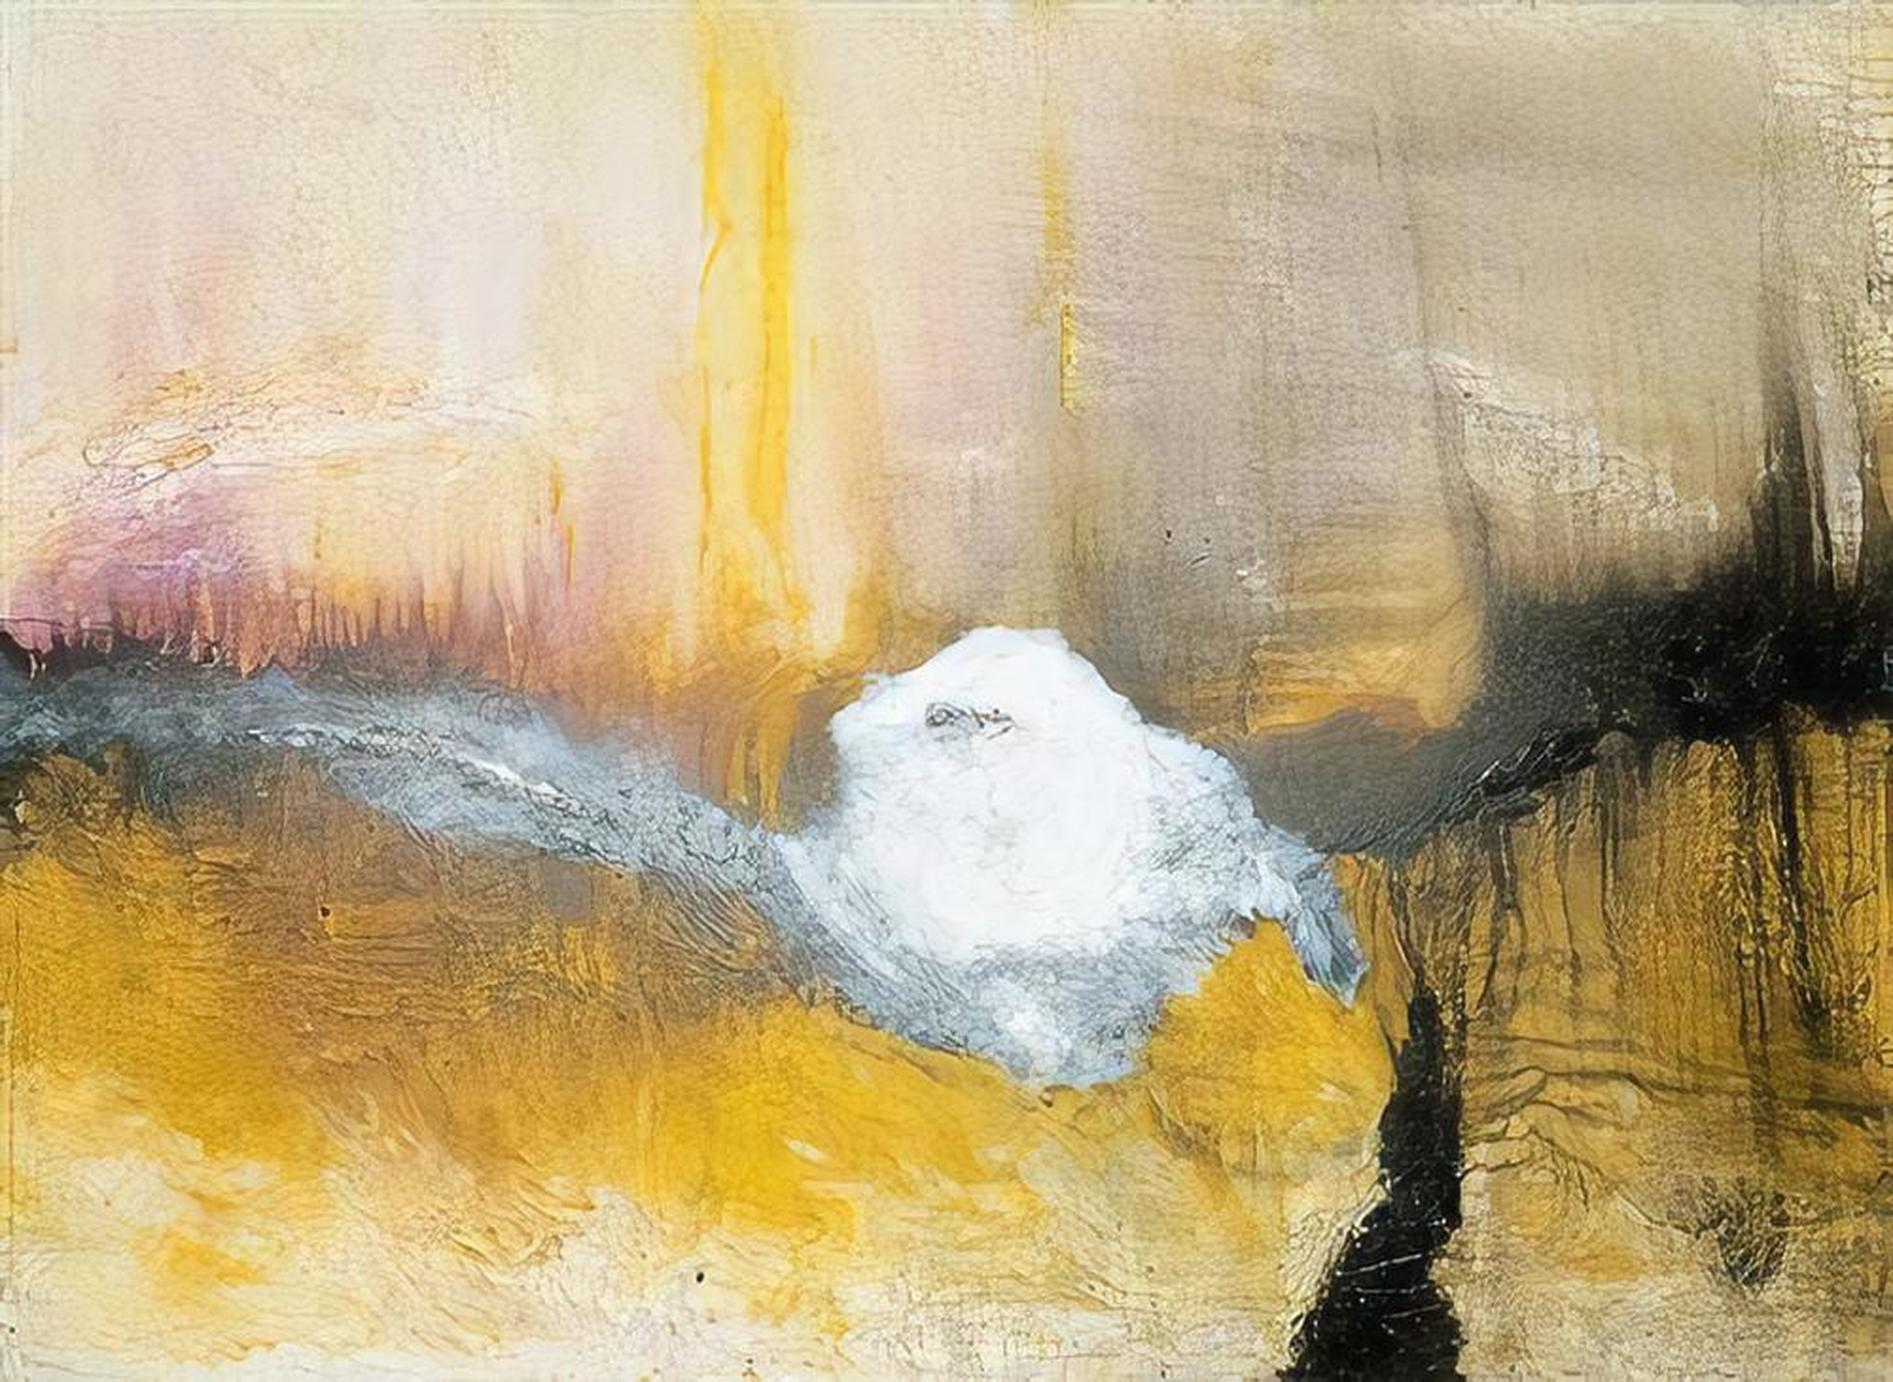

In [6]:
display(dataset[0]["image"])